### Importing basic libraries and packages

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [570]:
train = pd.read_csv(r'C:\Users\prasad\Downloads\Black Friday sales prediction\train_v9rqX0R.csv')
test = pd.read_csv(r'C:\Users\prasad\Downloads\Black Friday sales prediction\test_AbJTz2l.csv')

In [571]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [572]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [573]:
train.shape

(8523, 12)

In [574]:
catcols = train.select_dtypes(include = 'O').columns.values
numcols = train.select_dtypes(include = 'number').columns.values

In [575]:
for cols in catcols:
    print(cols)
    print(train[cols].value_counts(normalize = True)*100)
    print('------------------------------------------------------------------------------')

Item_Identifier
FDW13    0.117330
FDG33    0.117330
FDT07    0.105597
FDX31    0.105597
NCB18    0.105597
           ...   
FDC23    0.011733
DRF48    0.011733
FDN52    0.011733
FDQ60    0.011733
FDT35    0.011733
Name: Item_Identifier, Length: 1559, dtype: float64
------------------------------------------------------------------------------
Item_Fat_Content
Low Fat    59.709023
Regular    33.896515
LF          3.707615
reg         1.372756
low fat     1.314091
Name: Item_Fat_Content, dtype: float64
------------------------------------------------------------------------------
Item_Type
Fruits and Vegetables    14.455004
Snack Foods              14.079549
Household                10.676992
Frozen Foods             10.043412
Dairy                     8.001877
Canned                    7.614690
Baking Goods              7.602957
Health and Hygiene        6.101138
Soft Drinks               5.221166
Meat                      4.986507
Breads                    2.944972
Hard Drinks         

# Univariate distribution of features

## Numerical variable distribution

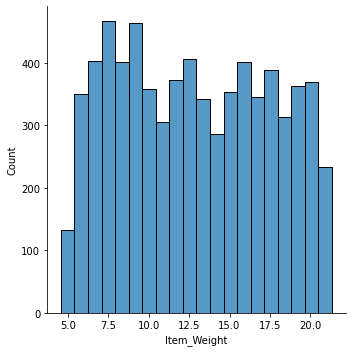

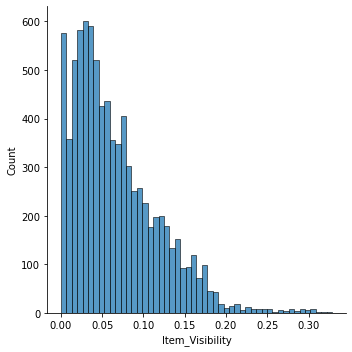

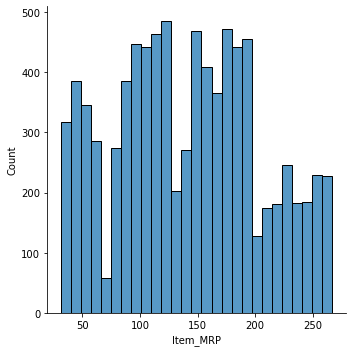

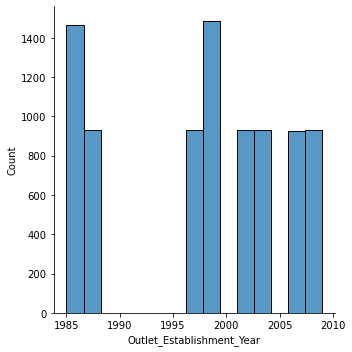

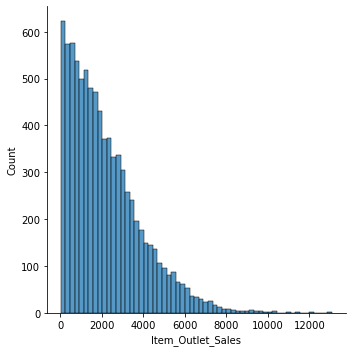

In [576]:
for cols in numcols:
    sns.displot(train[cols])
    plt.show()

In [577]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'LF':'Low Fat', 'reg': 'Regular', 'low fat':'Low Fat', 'Low Fat': 'Low Fat', 'Regular': 'Regular'})
test['Item_Fat_Content'] = test['Item_Fat_Content'].map({'LF':'Low Fat', 'reg': 'Regular', 'low fat':'Low Fat', 'Low Fat': 'Low Fat', 'Regular': 'Regular'})

## Categorical Variable countplots

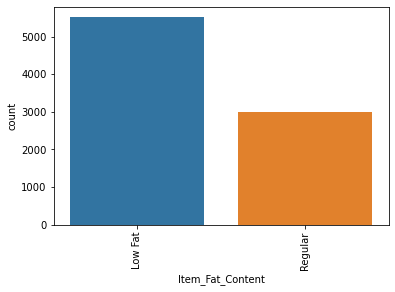

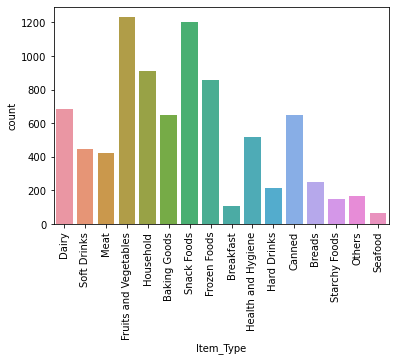

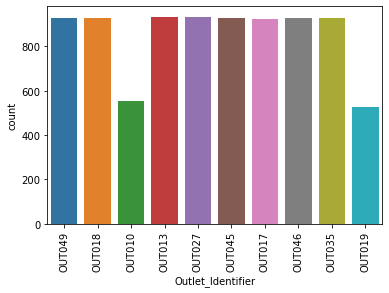

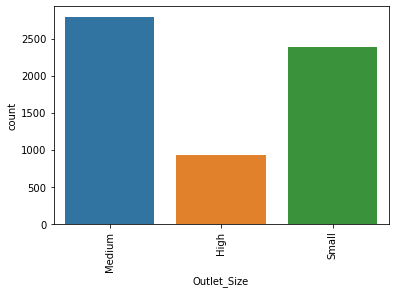

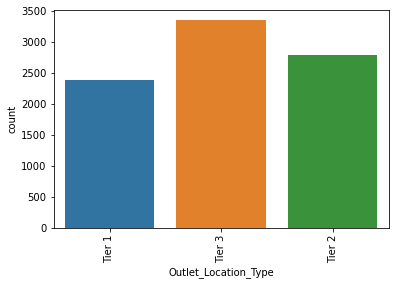

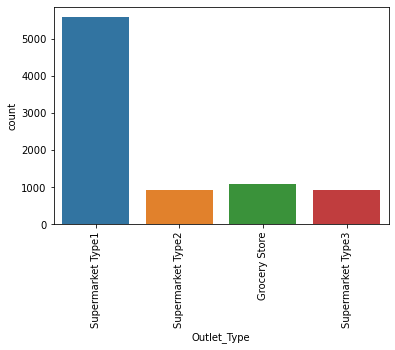

In [578]:
for cols in catcols:
    if cols =='Item_Identifier':
        continue
    else:
        sns.countplot(x = train[cols])
        plt.xticks(rotation = 90)
        plt.show()

### Distribution of the target  features wrt to other features 

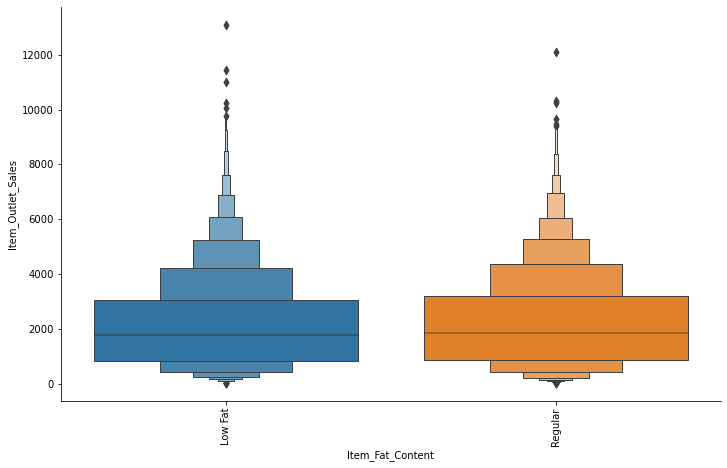

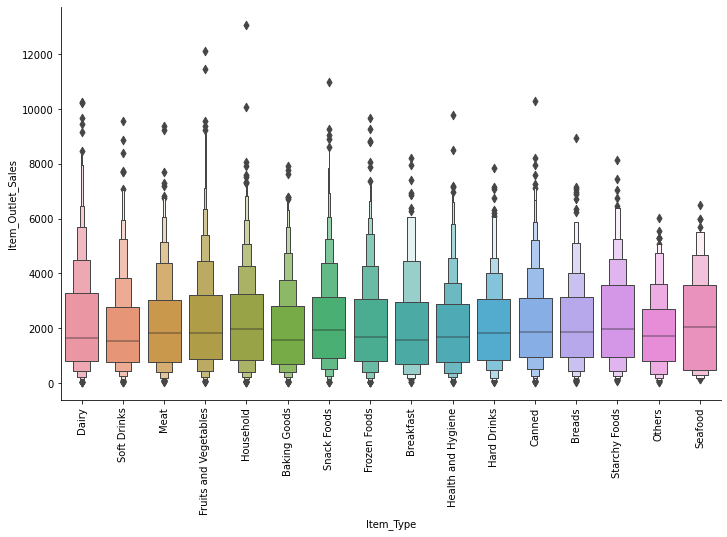

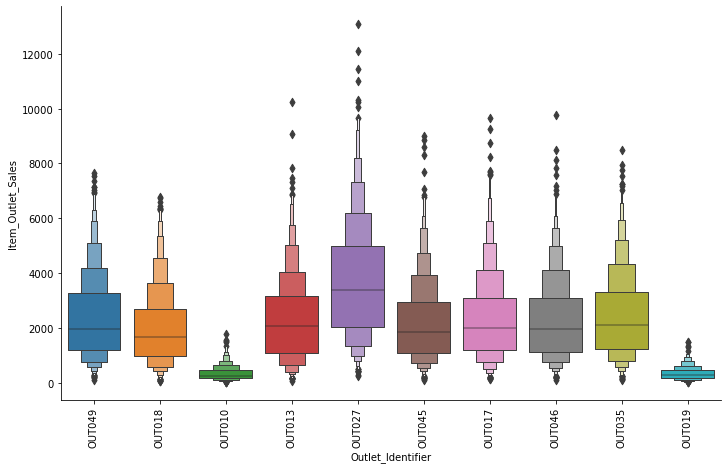

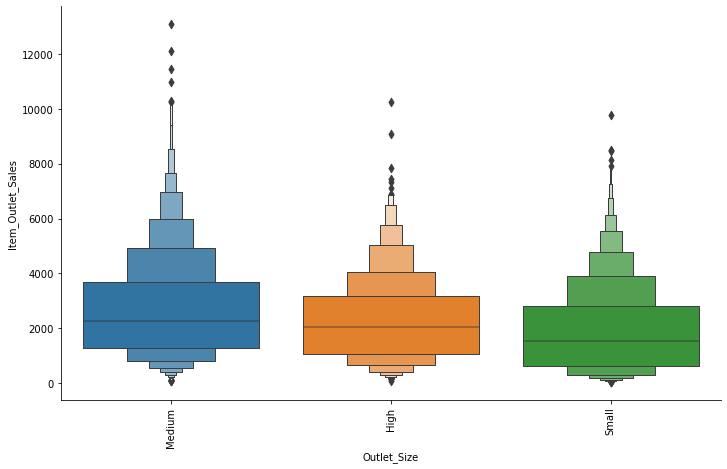

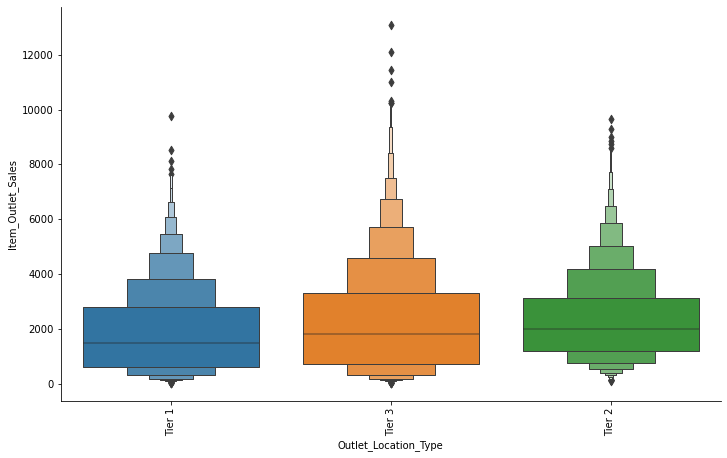

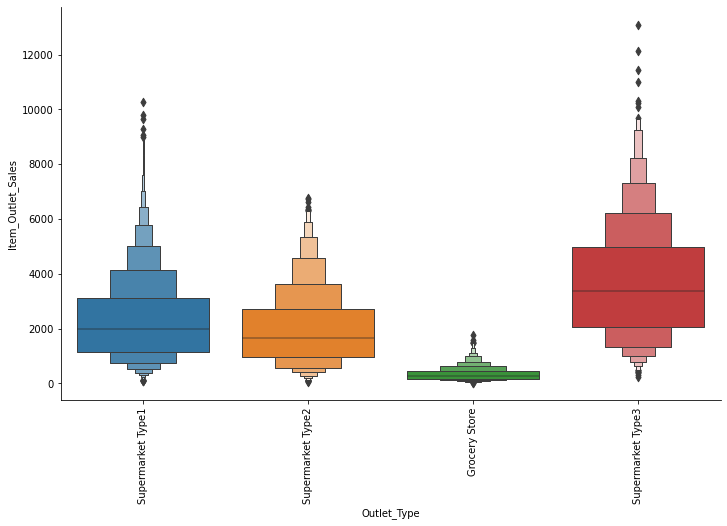

In [579]:

for cols in catcols:
    if cols =='Item_Identifier':
        continue
    else:
        sns.catplot(data = train, x =cols, y = 'Item_Outlet_Sales' , kind = 'boxen', height = 6, aspect = 10/6)
        plt.xticks(rotation =90)
        plt.show()

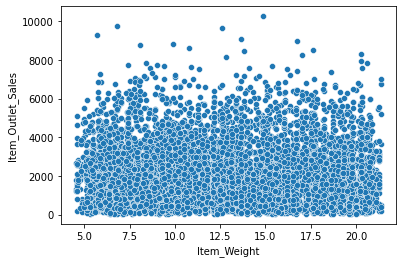

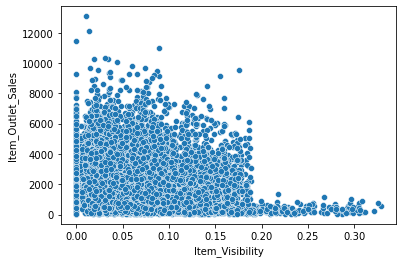

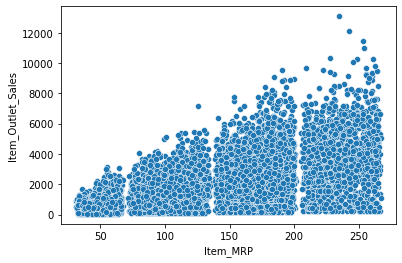

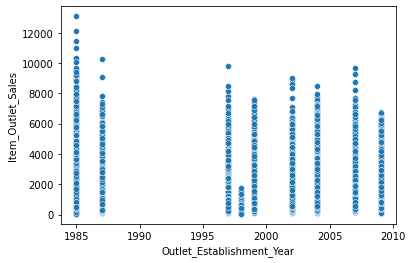

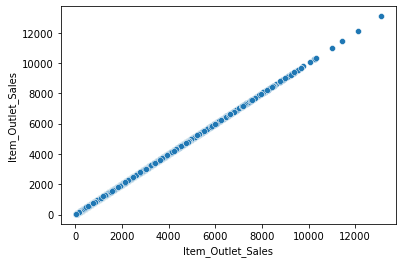

In [580]:
for cols in numcols:
    sns.scatterplot(data = train, x = cols, y = 'Item_Outlet_Sales')
    plt.show()

### Finding the top 10 item types by total sales

<BarContainer object of 10 artists>

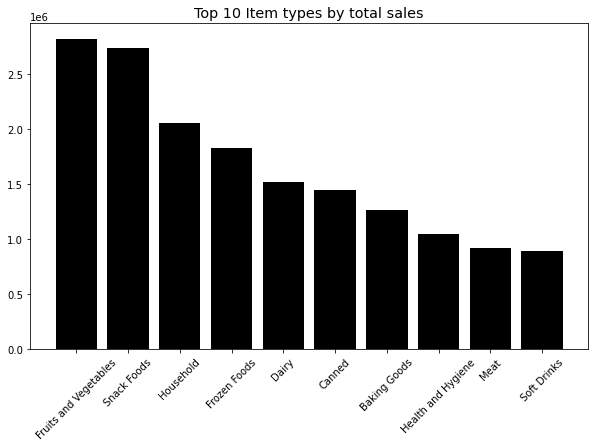

In [589]:
plt.figure(figsize = (10,6))
plt.xticks(rotation  = 45)
plt.title('Top 10 Item types by total sales', fontsize = 'x-large')
plt.bar(color = 'black', height = train.pivot_table(index = [ 'Item_Type'], aggfunc = {'Item_Outlet_Sales':'sum','No_of_Items':'sum', 'Item_MRP': 'mean' }).nlargest(10, 'Item_Outlet_Sales')['Item_Outlet_Sales'], x = train.pivot_table(index = [ 'Item_Type'], aggfunc = {'Item_Outlet_Sales':'sum','No_of_Items':'sum', 'Item_MRP': 'mean' }).nlargest(10, 'Item_Outlet_Sales').index)

### Importing basic modules and packages for machine learning 

In [530]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### Looks like some items have missing weights. Imputing the missing values in the weight feature by selecting the related values in other entries having same Item_Id, since they would have the same weight if they are the same items. Creating a dictionary for all the items that have some weight already in the train data

In [590]:
missing = train.loc[train.isnull().iloc[:, 1]]['Item_Identifier'].values

In [591]:
train.loc[train.isnull().iloc[:, 1]] = train.loc[train.isnull().iloc[:, 1]].fillna('None')

In [592]:
dicts = {}
for i in range(len(train)):
    if train.iloc[i, 0] in dicts:
        continue
    else:
        if train.iloc[i, 1] =='None':
            continue
        dicts[train.iloc[i, 0]]=train.iloc[i, 1]

### Out of the 1559 unique Items, 1555 of them have some weight asociated with them, so entries corresponding to these can be filled exactly without using mean, median

In [593]:
len(dicts)

1555

In [594]:
train.loc[train['Item_Identifier'].isin([keys for keys in train['Item_Identifier'].values if keys not in dicts.keys()])]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_of_Items
927,FDN52,None,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564,18.062126
1922,FDK57,None,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280,36.938356
4187,FDE52,None,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046,38.824623
5022,FDQ60,None,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098,0.994225


In [595]:
dicts['FDN52']=0
dicts['FDK57']=0
dicts['FDE52']=0
dicts['FDQ60']=0

#### Rest 4 of the items are first initialized to 0 to map the entire dictionary on the weights column

### Filling the weights values according to the dictionary collected from the data, train and test data

In [596]:
for i in range(len(train)):
    train.iloc[i, 1]=dicts[train.iloc[i, 0]]
    

In [597]:
for i in range(len(test)):
    test.iloc[i, 1]=dicts[test.iloc[i, 0]]
    

In [598]:
train.loc[train['Item_Identifier'].isin(['FDN52', 'FDK57', 'FDE52', 'FDQ60']), 'Item_Weight']=train['Item_Weight'].mean()

### Since the Outlet Size had more than 30% of missing values, and no way to fill them without consulting the stakeholders, dropping them

In [599]:
train.drop('Outlet_Size', axis = 1, inplace = True)
test.drop('Outlet_Size', axis = 1, inplace = True)

### Initialising Label Encoder and transforming the train and test data, initialising the models 

In [600]:
en = LabelEncoder()

In [601]:
for cols in catcols:
    if cols!='Outlet_Size':
        en.fit(train.loc[:, cols])
        train.loc[: , cols] = en.transform(train.loc[:, cols])
        test.loc[: , cols] = en.transform(test.loc[:, cols])

In [602]:
lin = LinearRegression()
tree = DecisionTreeRegressor()
forest   = RandomForestRegressor()
lasso =Lasso(alpha = 0.1)
las2 = Lasso()
models = [lin, tree, forest, lasso]

In [603]:
X = train.drop('Item_Outlet_Sales', axis = 1)
y =train.loc[: , 'Item_Outlet_Sales'] 

In [610]:
dics = {}
for model in models:
    dics[model] = cross_val_score(model, X, y, scoring ='neg_root_mean_squared_error' , cv = 5)

### Base predictions on some of the models only after imputing the missing values and some cleaning to have some baseline

In [611]:
pd.DataFrame(dics).mean()

LinearRegression()        -568.184886
DecisionTreeRegressor()   -108.301277
RandomForestRegressor()    -58.464009
Lasso(alpha=0.1)          -568.183162
dtype: float64

### Trying a hyperparameter tuning on lasso, to see improvements and get an idea of which features are considered by the regularization, as Lasso does automatic feature selection

In [444]:
param = np.logspace(-3,1,5)
search = GridSearchCV(lasso, param_grid = {'alpha':param}, cv = 5, scoring = 'neg_mean_squared_error')
search.fit(X, y)
print(search.best_score_)
print(search.best_params_)

-1454568.125127287
{'alpha': 0.1}


### Features used by the Lasso Model

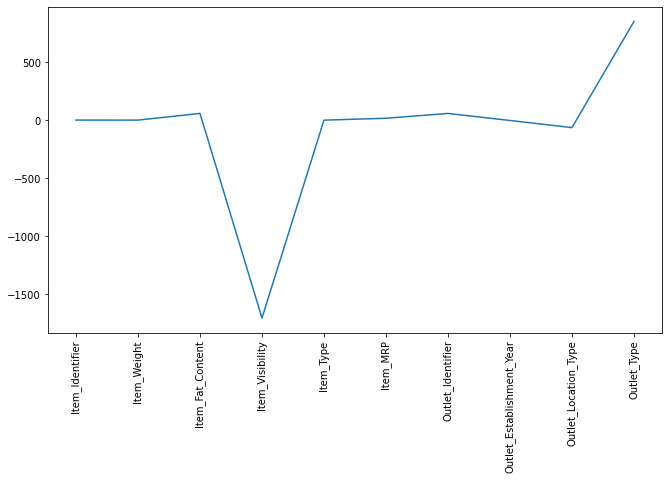

In [466]:
lasso.fit(X, y)
plt.figure(figsize = (11,6))
plt.plot(X.columns,  lasso.coef_)
plt.xticks(rotation =90)
plt.show()

### Correlation of the target feature with other features

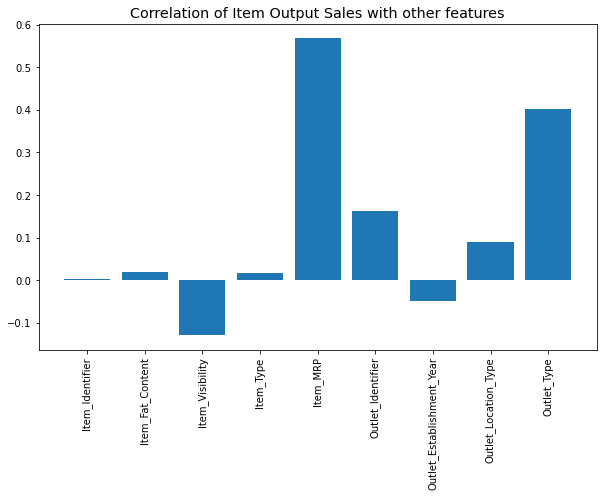

In [490]:
plt.figure(figsize = (10,6))
plt.bar(height = train.corr().loc[: , 'Item_Outlet_Sales'].values[:-1], x = train.corr().loc[: , 'Item_Outlet_Sales'].index[:-1])
plt.xticks(rotation = 90)
plt.title('Correlation of Item Output Sales with other features', fontsize = 'x-large')
plt.show()

### Trying some preliminary feature selection, selecting just 5 best features

In [511]:
from sklearn.feature_selection import  SelectKBest, f_regression

In [604]:
select = SelectKBest(f_classif, k = 5)

In [605]:
X_sel =select.fit_transform(X, y)

In [606]:
dics = {}
for model in models:
    dics[model] = cross_val_score(model, X_sel, y, scoring ='neg_root_mean_squared_error' , cv = 5)

In [608]:
pd.DataFrame(dics).mean()

LinearRegression()        -568.222310
DecisionTreeRegressor()   -101.577558
RandomForestRegressor()    -51.832408
Lasso(alpha=0.1)          -568.223063
dtype: float64

### There is some improvement after feature selection for Decision tree and Random Forest models

In [637]:
from sklearn.feature_selection import RFE
selector = RFE(lasso)
X_fit =selector.fit_transform(X, y) 

In [638]:
dic2 = {}
for model in models:

    dic2[model] = cross_val_score(model, X_fit, y, cv = 5, scoring  = 'neg_root_mean_squared_error').mean()
    print(model)

LinearRegression()
DecisionTreeRegressor()
RandomForestRegressor()
Lasso(alpha=0.1)


In [639]:
pd.Series(dic2)

LinearRegression()        -568.148655
DecisionTreeRegressor()   -101.969775
RandomForestRegressor()    -51.247132
Lasso(alpha=0.1)          -568.149222
dtype: float64